In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import time

# cells defined in earlier notebooks

In [2]:
def saddle_node_locator(ss_list):
    """
    find point where steady state (ss) jumps (hysteresis)
    where unsteady state manifold appears/disappears
    """
    for n,(i,j) in enumerate(zip(ss_list[:-1], ss_list[1:])):
        if abs(j-i) > 0.3:
            return n+1

# defining the phenomenological model

In [3]:
def R_pheno(A,t):
    """
    system of ODEs simplifying the Zaytsev 2016 mass-action model, using:
    - Michaelis constants (Kr, Kr) to describe both binding + product formation
    - Hill coefficients (n, m) to describe nonlinear activity
    """
    phos = cis + trans*A**n/(Kf**n + A**n)
    dephos = inact*P*Kr**m/(Kr**m + A**m)
    return phos*(Atot - A) - dephos*A

In [4]:
"""
parameters for the phenomenological model chosen for conceptual simplicity
"""

cis   = .01   # to reflect large difference between 'in cis' & 'in trans' reaction rates
trans = 1
inact = 1
Kf    = 1
Kr    = 1
n = 2         # Hill coefficient > 1 to reflect nonlinear activation
m = 1         # Hill coefficient = 1 to reflect linear inactivation

In [5]:
"""
algorithm to find steady states + unsteady state manifold in the bistable regions
of the phenomenological system at different phosphatase concentrations
"""
start = time.time()
## algorithm takes <1 min

tspan = np.linspace(0,10*60,1000)
Atot_range = np.arange(0,5,.01)

bistab_curves_var_P = []

for P in [.25,.5,.75]:
    
    lo_list = []
    hi_list = []
    Atot_bistable_list = []
    bistable_list = []

    for Atot in Atot_range:

        y = odeint(R_pheno,0,tspan)
        lo_ss = y[-1][0]
        lo_list.append(lo_ss)

        y = odeint(R_pheno,Atot,tspan)
        hi_ss = y[-1][0]
        hi_list.append(hi_ss)

        if not np.isclose(lo_ss, hi_ss, atol=.1):
            Atot_bistable_list.append(Atot)
            bistable_list.append((Atot, lo_ss, hi_ss))

    unstablemanifold_list = []
    for Atot, lo_ss, hi_ss in bistable_list:
        A0 = lo_ss
        A_sim = np.zeros(1)
        A_sim[-1] = -1
        while A_sim[-1] < A0:
            A0 += .01
            A_sim = odeint(R_pheno,A0,tspan)
        unstablemanifold_list.append(A0)

    n_lo = saddle_node_locator(lo_list)
    n_hi = saddle_node_locator(hi_list)

    saddle_x = [Atot_range[n_hi]] + Atot_bistable_list + [Atot_range[n_lo-1]]
    saddle_y = [hi_list[n_hi]] + unstablemanifold_list + [lo_list[n_lo-1]]
    
    bistab_curves_var_P.append((P,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y))
    
end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.8 min


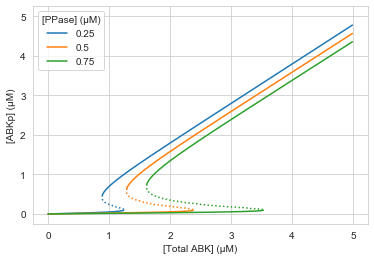

In [6]:
"""
Figure 8A
plots bistability curve results of the above algorithm as related to total kinase concentration
- demonstrates balance between activation + inactivation feedback loops
- as phosphatase increases, the bottom branch (low steady state) lengthens relative to the top, 
showing an increase in the relative strength of the negative feedback loop
"""

colors = ['C0','C1','C2']
colors_dot = ['C0:','C1:','C2:']

for (P,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y),color,color_dot in zip(bistab_curves_var_P,colors,colors_dot):
    plt.plot(Atot_range[:n_lo], lo_list[:n_lo], color, label=f'{P}')
    plt.plot(Atot_range[n_hi:], hi_list[n_hi:], color)
    plt.plot(saddle_x,saddle_y, color_dot)
    
plt.legend(title='[PPase] (\u03BCM)')
plt.xlabel('[Total ABK] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.ylim(-5*.05, 5*1.05);

In [7]:
"""
algorithm to find steady states + unsteady state manifold in the bistable regions
of the phenomenological system at different phosphatase concentrations
plotted with phosphatase concentration as the x-axis
"""
start = time.time()
## algorithm takes <1 min

tspan = np.linspace(0,10*60,1000)
P_range = np.arange(0,2,.01)

bistab_curves_var_Atot = []

for Atot in [1.5,2,2.5]:
    
    lo_list = []
    hi_list = []
    P_bistable_list = []
    bistable_list = []

    for P in P_range:

        y = odeint(R_pheno,0,tspan)
        lo_ss = y[-1][0]
        lo_list.append(lo_ss)

        y = odeint(R_pheno,Atot,tspan)
        hi_ss = y[-1][0]
        hi_list.append(hi_ss)

        if not np.isclose(lo_ss, hi_ss, atol=.1):
            P_bistable_list.append(P)
            bistable_list.append((P, lo_ss, hi_ss))

    unstablemanifold_list = []
    for P, lo_ss, hi_ss in bistable_list:
        A0 = lo_ss
        A_sim = np.zeros(1)
        A_sim[-1] = -1
        while A_sim[-1] < A0:
            A0 += .01
            A_sim = odeint(R_pheno,A0,tspan)
        unstablemanifold_list.append(A0)

    n_lo = saddle_node_locator(lo_list)
    n_hi = saddle_node_locator(hi_list)

    saddle_x = [P_range[n_lo]] + P_bistable_list + [P_range[n_hi-1]]
    saddle_y = [lo_list[n_lo]] + unstablemanifold_list + [hi_list[n_hi-1]]
    
    bistab_curves_var_Atot.append((Atot,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y))

end = time.time()
print(f'~ {round( (end - start)/60, 1 )} min')

~ 0.7 min


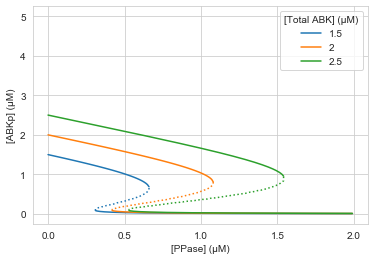

In [8]:
"""
Figure 8B
plots bistability curve results of the above algorithm as related to phosphatase concentration
- as total kinase increases, the top branch (high steady state) lengthens relative to the bottom, 
showing an increase in the relative strength of the positive feedback loop
"""

colors = ['C0','C1','C2']
colors_dot = ['C0:','C1:','C2:']

for (Atot,lo_list,n_lo,hi_list,n_hi,saddle_x,saddle_y),color,color_dot in zip(bistab_curves_var_Atot,colors,colors_dot):
    plt.plot(P_range[n_lo:], lo_list[n_lo:], color, label=f'{Atot}')
    plt.plot(P_range[:n_hi], hi_list[:n_hi], color)
    plt.plot(saddle_x,saddle_y, color_dot)
    
plt.legend(title='[Total ABK] (\u03BCM)')
plt.xlabel('[PPase] (\u03BCM)')
plt.ylabel('[ABKp] (\u03BCM)')
plt.ylim(-5*.05, 5*1.05)
plt.locator_params(axis='x', nbins=5);